In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Loading the dataset & Pre trained word embeddings

In [2]:
import os
import sys
import torch
import torchtext.data
import torchtext.datasets
import numpy as np 
import time
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from cs236781.train_results import FitResult
from cs236781 import plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)

device = cuda


load the data set:

In [3]:
if os.sys.platform == 'linux':
    data_dir = os.path.expanduser('~/HW4/project/GloVe')
else:
    data_dir = os.path.expanduser('~/.pytorch-datasets')
    
# torchtext Field objects parse text (e.g. a review) and create a tensor representation

# This Field object will be used for tokenizing the movie reviews text
review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

# This Field object converts the text labels into numeric values (0,1,2)
label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

# Load SST, tokenize the samples and labels
# ds_X are Dataset objects which will use the parsers to return tensors
ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
    review_parser, label_parser, root=data_dir
)

n_train = len(ds_train)
print(f'Number of training   samples: {n_train}')
print(f'Number of validation samples: {len(ds_valid)}')
print(f'Number of test       samples: {len(ds_test)}')

/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/example.py

Number of training   samples: 8544
Number of validation samples: 1101
Number of test       samples: 2210


As required, we'll use the pre-trained word embeddings of glove 6B.

In [4]:
#Vocabulary size is 40k, Embedding chosen size in 50
vocab, embeddings = [],[]
with open('./GloVe/glove.6B.200d.txt','rt',encoding='utf8') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)
    

add padding and unknown tokens to the embeddings array:

In [5]:
# Add the padding and the unknown tokens to the vocab and embeddings arrays

vocab = np.array(vocab) 
embeddings = np.array(embeddings)
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')

unk_emb = np.mean(embeddings, axis=0, keepdims=True)
pad_emb = np.zeros_like(embeddings[0]).reshape(1,-1)


embeddings = np.vstack((pad_emb, unk_emb, embeddings))

print(embeddings.shape)
print(vocab[:10])

(400003, 200)
['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']


## Train loop 

In [6]:
def train(model, optimizer, loss_fn, dl_train, dl_test, max_epochs=100,
          num_batches=400, print_every=1, save_path=None):
    
    best_test_acc = 0
    res = FitResult(max_epochs,[],[],[],[] )
    
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        num_samples = 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dl_train):
            X, y = batch.text, batch.label

            # Forward pass
            _, y_pred_log_proba = model(X)
            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_samples += y_pred.shape[0]
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == num_batches-1:
                break
        
        curr_test_loss, curr_test_acc = test_epoch(model, loss_fn, dl_test, print_acc=(epoch_idx % print_every == 0))
        res.test_loss.append(curr_test_loss)
        res.test_acc.append(curr_test_acc)
        
        curr_train_loss = total_loss /(num_batches)
        curr_train_acc = num_correct /(num_samples)
        res.train_loss.append(curr_train_loss)
        res.train_acc.append(curr_train_acc)
        
        if epoch_idx % print_every == 0:
            print(f"Epoch #{epoch_idx}, loss={curr_train_loss:.3f}, accuracy={curr_train_acc:.3f}, elapsed={time.time()-start_time:.1f} sec")
        
        if save_path and curr_test_acc > best_test_acc:
            if epoch_idx % print_every == 0:
                print("---saving model ---")
            torch.save(model, save_path)
            best_test_acc = curr_test_acc
            
    return res

In [7]:
def test_epoch(model, loss_fn, dataloader, print_acc=False):
    model.eval()
    total_loss = 0
    num_correct = 0 
    num_batches = 0
    num_samples = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            num_batches = batch_idx
            X, y = batch.text, batch.label

            _, y_test = model(X)
            loss = loss_fn(y_test, y)
            total_loss += loss.item()
            
            # Calculate accuracy
            y_pred = torch.argmax(y_test, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            num_samples += y_pred.shape[0]

        num_batches += 1   
        
        test_loss = total_loss /(num_batches)
        test_acc = num_correct /(num_samples)
        if print_acc:
            print("Test Accuracy is ----", test_acc, "-----")

    model.train()
    return test_loss, test_acc

## Baseline Model - Sentiment Analysis using RNN - GRU

As for the first part in our experiment


In [8]:
BATCH_SIZE = 128
HIDDEN_SIZE = 100
NUM_LAYERS = 2
DROPOUT = 0.5
FREEZE_EMBEDDINGS = False

LOSS_WEIGHTS = [1., 1., 1.]

WEIGHT_DECAY = 0  # 1e-5
LEARNING_RATE = 2e-4
BETAS = (0.95, 0.98)  # this is the best for stable training, default is (0.99, 0.999), 

In [9]:
dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [1]:
# defining the baseline model
from RNN import SentimentGRU

model = SentimentGRU(embeddings,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS,
                     dropout=DROPOUT,
                     freeze_embedding=FREEZE_EMBEDDINGS).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=WEIGHT_DECAY,
                             betas=BETAS)

loss_fn = torch.nn.NLLLoss()


NameError: name 'embeddings' is not defined

In [ ]:
fit_res = train(model, optimizer, loss_fn, dl_train, dl_test, max_epochs=100,
      num_batches=500, save_path = "./models/sentimentGRU.pt")

In [1]:
plot.plot_fit(fit_res)

NameError: name 'plot' is not defined

In [13]:
# Load the best model achieved during training
model = torch.load("./models/sentimentGRU.pt")
print(model)

RuntimeError: [enforce fail at inline_container.cc:144] . PytorchStreamReader failed reading zip archive: failed finding central directory

# Self Attention Model

In [27]:
# Self Attenttion Hyper parameters:

BATCH_SIZE = 128 # best so far
NUM_HEADS = 1 # does not matter alot
D_MODEL = 50 
TWO_LAYERS = False
FREEZE_EMB = False # weather to fine tune the embedding
DROPOUT = 0.8 # best with the combination of weight decay
KQV_DROPOUT = 0 # no dropout there in the paper
DENSE_DROPOUT = 0

LOSS_WEIGHT = [1., 1., 1.] # 

LEARNING_RATE = 1e-4  # best so far, dont change
WEIGHT_DECAY = 3e-3  # best so far, dont change
BETAS = (0.95, 0.98)  # this is the best for stable training, default is (0.99, 0.999), 

## Run before trainning new model from scratch:

In [28]:
from SelfAttention import SentimentSelfAttention

dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

model_attention = SentimentSelfAttention(embeddings,
                                         d_model=D_MODEL,
                                         num_heads=NUM_HEADS,
                                         dropout=DROPOUT,
                                         kqv_dropout=KQV_DROPOUT,
                                         two_layers=TWO_LAYERS,
                                         freeze_embedding=FREEZE_EMB,
                                         dense_dropout=DENSE_DROPOUT).to(device)

att_optimizer = torch.optim.Adam(model_attention.parameters(), lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY, betas=BETAS)

loss_fn = torch.nn.NLLLoss(weight=torch.tensor(LOSS_WEIGHT).to(device))

print("trainable params:", 
      sum(p.numel() for p in model_attention.parameters() if p.requires_grad)) 


trainable params: 80044053


Run only when trainning model that has been saved:

In [ ]:
Attention_res = train(model_attention, att_optimizer, loss_fn, dl_train, dl_test, max_epochs=200,
          num_batches=500, save_path="./models/selfAttentionGlove200.pt")

In [13]:
model_attention = torch.load("./models/selfAttentionGlove200.pt")
att_optimizer = torch.optim.Adam(model_attention.parameters(), lr=LEARNING_RATE, 
                                 weight_decay=WEIGHT_DECAY, betas=BETAS)
# loss_fn = torch.nn.NLLLoss(weight=torch.tensor([1., 1., 2.]).to(device))
# model_attention.embedding_layer.weight.requires_grad = False

(<Figure size 1152x720 with 4 Axes>,
 array([<AxesSubplot:title={'center':'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <AxesSubplot:title={'center':'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <AxesSubplot:title={'center':'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <AxesSubplot:title={'center':'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

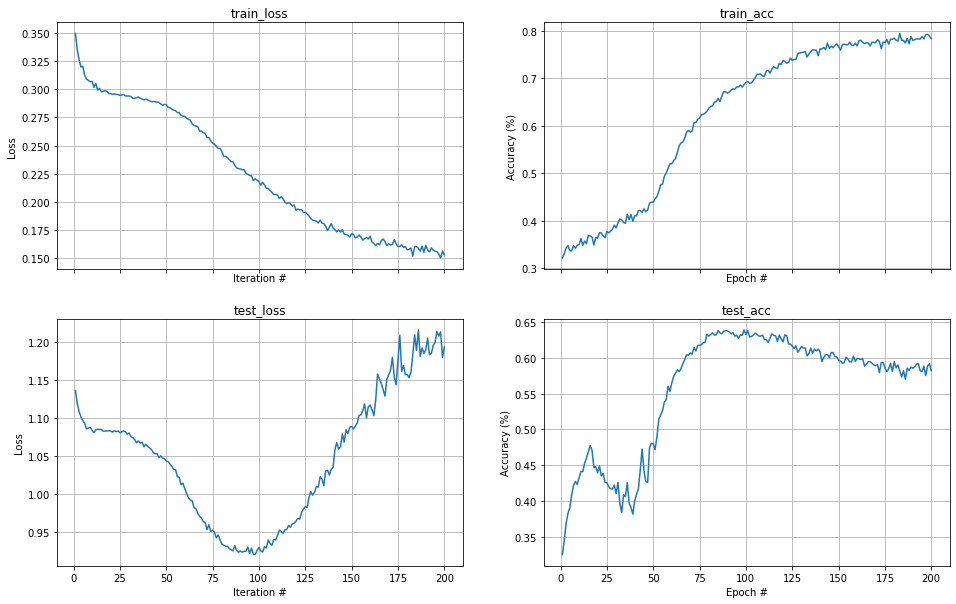

In [14]:
plot.plot_fit(Attention_res)

tensor([0., 2., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


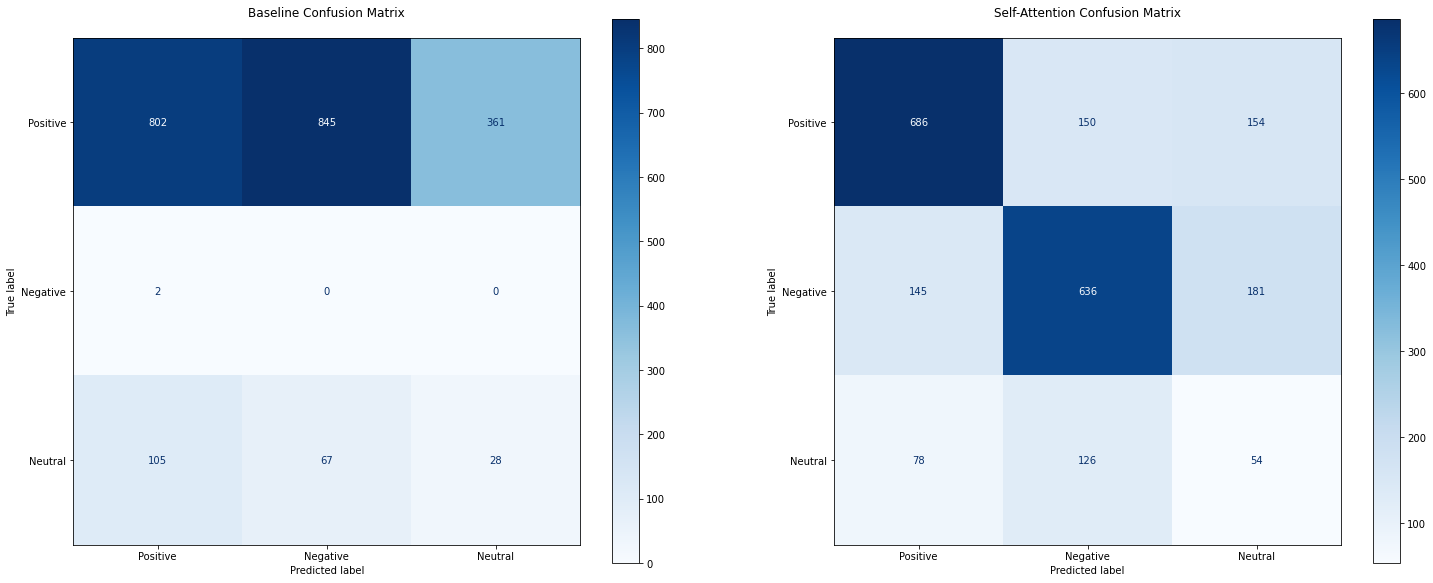

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

# get the best predictions from the model
def get_preds_and_labels(model, dl, device):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    GT_labels = torch.tensor([]).to(device)

    for i,batch in enumerate(dl):
        X, y = batch
        
        _, preds = model(X)
        preds = torch.argmax(preds, dim=1)
        
        
        all_preds = torch.cat((all_preds, preds), dim=0)
        GT_labels = torch.cat((GT_labels, y), dim=0)
    model.train()
    print(all_preds)
    return all_preds , GT_labels

with torch.no_grad():
    # baseline VS SelfAttention Confusion matrices
    bl_best_preds, bl_GT_preds= get_preds_and_labels(model, dl_test, device)
    se_best_preds, se_GT_preds = get_preds_and_labels(model_attention, dl_test, device)
    
    # Now lets demonstrate the confusion matrix of the test set.
    IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
    class_names = ['Positive','Negative','Neutral']

    fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1 , figsize=(25, 10))
    disp = plot_confusion_matrix(IC, bl_GT_preds.cpu(), bl_best_preds.cpu() ,display_labels=class_names, cmap=plt.cm.Blues,  ax=ax1);
    disp.ax_.set_title('Baseline Confusion Matrix\n')

    disp = plot_confusion_matrix(IC, se_GT_preds.cpu(), se_best_preds.cpu() ,display_labels=class_names, cmap=plt.cm.Blues,  ax=ax2);
    disp.ax_.set_title('Self-Attention Confusion Matrix\n')

# normalize='true',    

## Experiments:


test the affect of model size

Test Accuracy is ---- 0.41312217194570133 -----
Epoch #0, loss=0.300, accuracy=0.378, elapsed=3.6 sec
Test Accuracy is ---- 0.41312217194570133 -----
Epoch #10, loss=0.295, accuracy=0.393, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #20, loss=0.291, accuracy=0.418, elapsed=3.6 sec
Test Accuracy is ---- 0.6009049773755656 -----
Epoch #30, loss=0.270, accuracy=0.557, elapsed=3.6 sec
Test Accuracy is ---- 0.6416289592760182 -----
Epoch #40, loss=0.230, accuracy=0.655, elapsed=3.6 sec
Test Accuracy is ---- 0.6343891402714932 -----
Epoch #50, loss=0.205, accuracy=0.688, elapsed=3.6 sec
Test Accuracy is ---- 0.6375565610859728 -----
Epoch #60, loss=0.190, accuracy=0.715, elapsed=3.6 sec
Test Accuracy is ---- 0.6366515837104072 -----
Epoch #70, loss=0.180, accuracy=0.725, elapsed=3.6 sec
Test Accuracy is ---- 0.6352941176470588 -----
Epoch #80, loss=0.175, accuracy=0.733, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.41312217194570133 -----
Epoch #0, loss=0.299, accuracy=0.373, elapsed=3.6 sec
Test Accuracy is ---- 0.41266968325791853 -----
Epoch #10, loss=0.295, accuracy=0.386, elapsed=3.6 sec
Test Accuracy is ---- 0.46108597285067876 -----
Epoch #20, loss=0.291, accuracy=0.428, elapsed=3.6 sec
Test Accuracy is ---- 0.6063348416289592 -----
Epoch #30, loss=0.266, accuracy=0.576, elapsed=3.6 sec
Test Accuracy is ---- 0.6470588235294118 -----
Epoch #40, loss=0.230, accuracy=0.660, elapsed=3.6 sec
Test Accuracy is ---- 0.6380090497737556 -----
Epoch #50, loss=0.205, accuracy=0.696, elapsed=3.6 sec
Test Accuracy is ---- 0.6343891402714932 -----
Epoch #60, loss=0.190, accuracy=0.716, elapsed=3.6 sec
Test Accuracy is ---- 0.6294117647058823 -----
Epoch #70, loss=0.179, accuracy=0.733, elapsed=3.6 sec
Test Accuracy is ---- 0.6307692307692307 -----
Epoch #80, loss=0.175, accuracy=0.734, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.41266968325791853 -----
Epoch #0, loss=0.299, accuracy=0.386, elapsed=3.6 sec
Test Accuracy is ---- 0.416289592760181 -----
Epoch #10, loss=0.295, accuracy=0.392, elapsed=3.6 sec
Test Accuracy is ---- 0.4986425339366516 -----
Epoch #20, loss=0.287, accuracy=0.464, elapsed=3.6 sec
Test Accuracy is ---- 0.609049773755656 -----
Epoch #30, loss=0.267, accuracy=0.569, elapsed=3.6 sec
Test Accuracy is ---- 0.6461538461538462 -----
Epoch #40, loss=0.231, accuracy=0.658, elapsed=3.6 sec
Test Accuracy is ---- 0.63710407239819 -----
Epoch #50, loss=0.204, accuracy=0.693, elapsed=3.6 sec
Test Accuracy is ---- 0.63710407239819 -----
Epoch #60, loss=0.191, accuracy=0.715, elapsed=3.6 sec
Test Accuracy is ---- 0.630316742081448 -----
Epoch #70, loss=0.181, accuracy=0.729, elapsed=3.6 sec
Test Accuracy is ---- 0.6334841628959276 -----
Epoch #80, loss=0.176, accuracy=0.732, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.4122171945701357 -----
Epoch #0, loss=0.305, accuracy=0.375, elapsed=3.6 sec
Test Accuracy is ---- 0.3927601809954751 -----
Epoch #10, loss=0.294, accuracy=0.409, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #20, loss=0.291, accuracy=0.421, elapsed=3.6 sec
Test Accuracy is ---- 0.5841628959276018 -----
Epoch #30, loss=0.270, accuracy=0.562, elapsed=3.6 sec
Test Accuracy is ---- 0.6361990950226244 -----
Epoch #40, loss=0.231, accuracy=0.657, elapsed=3.6 sec
Test Accuracy is ---- 0.6380090497737556 -----
Epoch #50, loss=0.203, accuracy=0.694, elapsed=3.6 sec
Test Accuracy is ---- 0.6343891402714932 -----
Epoch #60, loss=0.190, accuracy=0.711, elapsed=3.6 sec
Test Accuracy is ---- 0.6289592760180995 -----
Epoch #70, loss=0.182, accuracy=0.722, elapsed=3.6 sec
Test Accuracy is ---- 0.6280542986425339 -----
Epoch #80, loss=0.173, accuracy=0.739, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.4122171945701357 -----
Epoch #0, loss=0.300, accuracy=0.380, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #10, loss=0.295, accuracy=0.387, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #20, loss=0.291, accuracy=0.414, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #30, loss=0.291, accuracy=0.423, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #40, loss=0.291, accuracy=0.423, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #50, loss=0.291, accuracy=0.423, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #60, loss=0.291, accuracy=0.423, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #70, loss=0.291, accuracy=0.423, elapsed=3.6 sec
Test Accuracy is ---- 0.4113122171945701 -----
Epoch #80, loss=0.291, accuracy=0.423, elapsed=3.6 sec


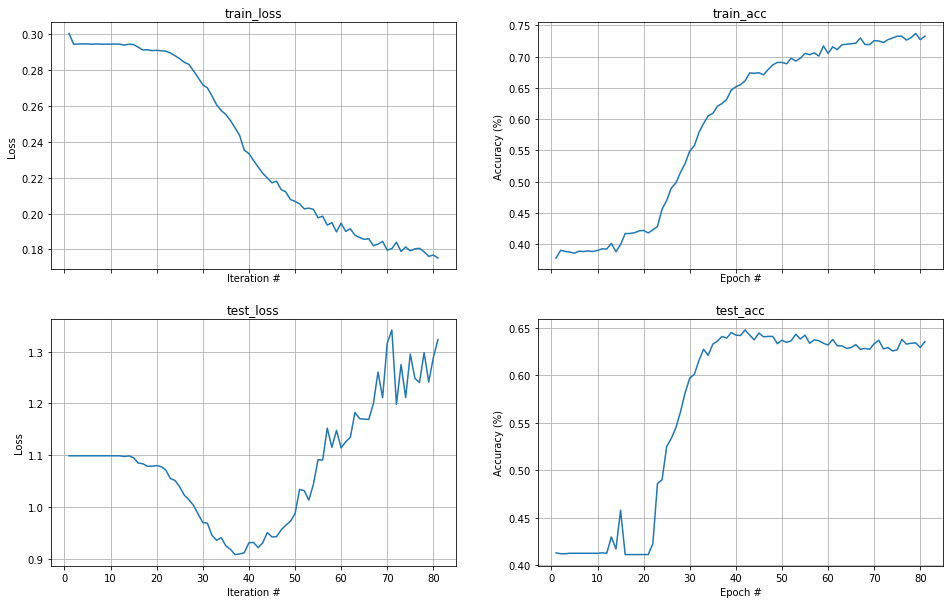

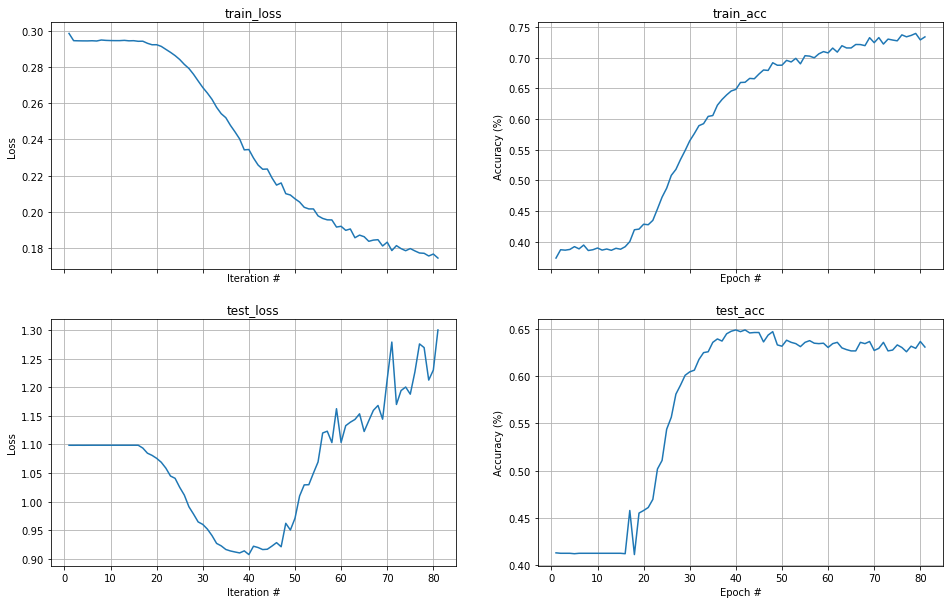

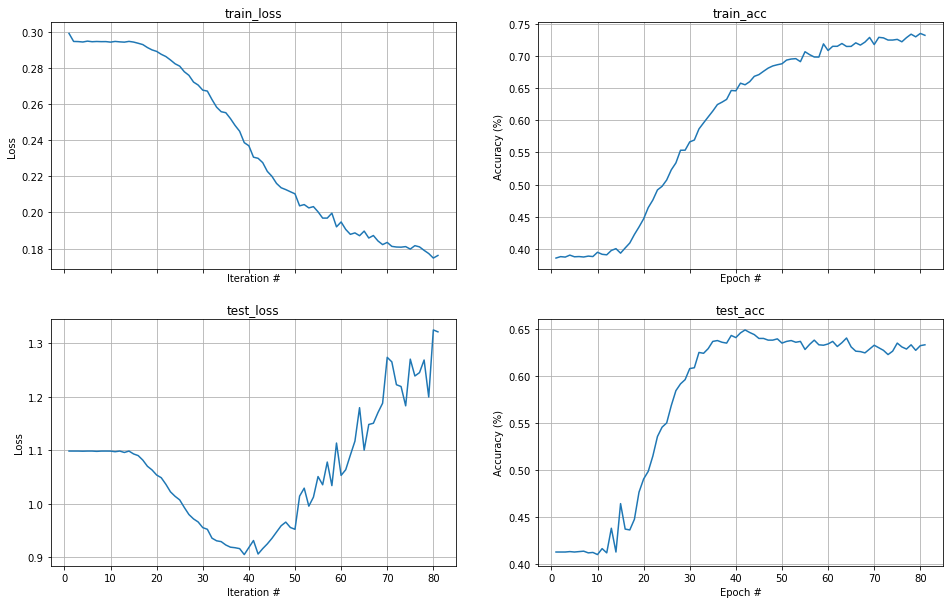

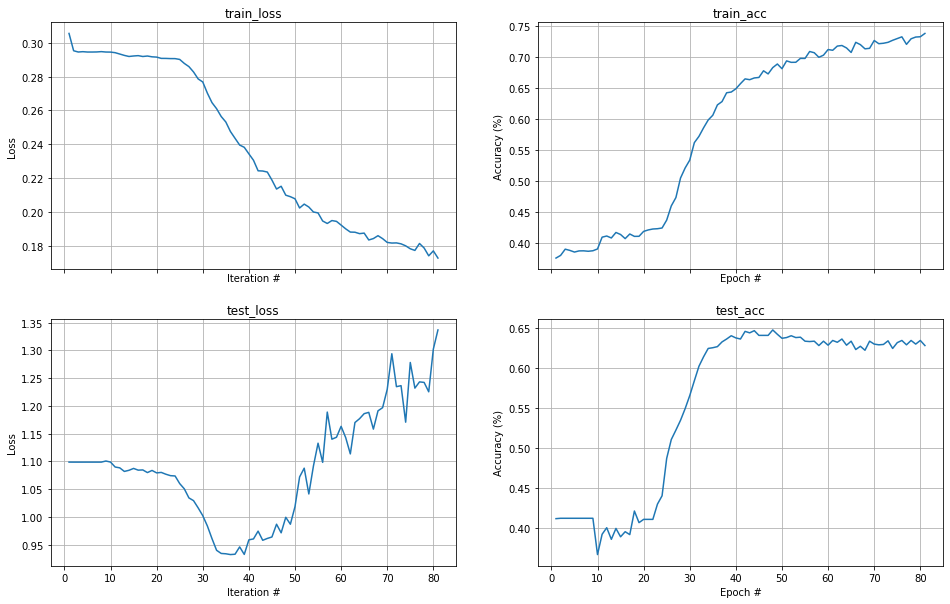

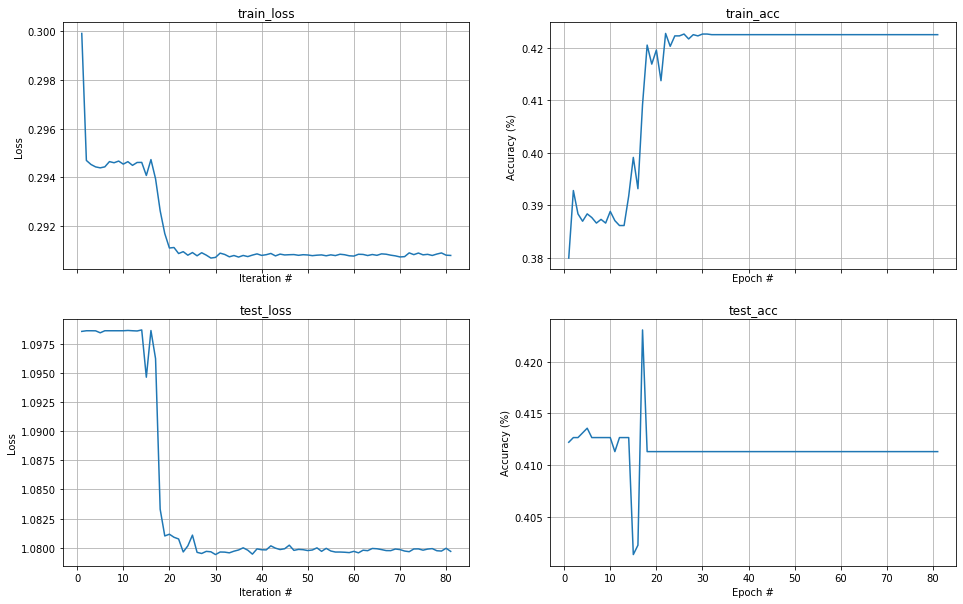

In [23]:
for d_model in [50, 70, 100, 150, 200]:
    dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
        (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
        shuffle=True, device=device)
    review_parser.build_vocab(ds_train)
    label_parser.build_vocab(ds_train)

    model_attention = SentimentSelfAttention(embeddings,
                                             d_model=D_MODEL,
                                             num_heads=NUM_HEADS,
                                             dropout=DROPOUT,
                                             kqv_dropout=KQV_DROPOUT,
                                             two_layers=TWO_LAYERS,
                                             freeze_embedding=FREEZE_EMB).to(device)

    att_optimizer = torch.optim.Adam(model_attention.parameters(), lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY, betas=BETAS)

    loss_fn = torch.nn.NLLLoss(weight=torch.tensor([1., 1., 1.5]).to(device))
    
    plot.plot_fit(train(model_attention, att_optimizer, loss_fn, dl_train, dl_test, max_epochs=81,
          num_batches=500, print_every=10))

test different numbers of heads:

/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.37918552036199094 -----
Epoch #0, loss=0.336, accuracy=0.345, elapsed=3.7 sec
Test Accuracy is ---- 0.42217194570135747 -----
Epoch #10, loss=0.299, accuracy=0.386, elapsed=3.6 sec
Test Accuracy is ---- 0.45475113122171945 -----
Epoch #20, loss=0.291, accuracy=0.422, elapsed=3.6 sec
Test Accuracy is ---- 0.5733031674208144 -----
Epoch #30, loss=0.278, accuracy=0.525, elapsed=3.6 sec
Test Accuracy is ---- 0.6434389140271494 -----
Epoch #40, loss=0.248, accuracy=0.632, elapsed=3.6 sec
Test Accuracy is ---- 0.646606334841629 -----
Epoch #50, loss=0.219, accuracy=0.674, elapsed=3.6 sec
Test Accuracy is ---- 0.6312217194570136 -----
Epoch #60, loss=0.205, accuracy=0.687, elapsed=3.6 sec
Test Accuracy is ---- 0.6212669683257919 -----
Epoch #70, loss=0.191, accuracy=0.711, elapsed=3.6 sec
Test Accuracy is ---- 0.6221719457013575 -----
Epoch #80, loss=0.181, accuracy=0.725, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.38371040723981903 -----
Epoch #0, loss=0.329, accuracy=0.347, elapsed=3.6 sec
Test Accuracy is ---- 0.4144796380090498 -----
Epoch #10, loss=0.297, accuracy=0.390, elapsed=3.6 sec
Test Accuracy is ---- 0.483710407239819 -----
Epoch #20, loss=0.290, accuracy=0.446, elapsed=3.6 sec
Test Accuracy is ---- 0.5819004524886878 -----
Epoch #30, loss=0.278, accuracy=0.527, elapsed=3.6 sec
Test Accuracy is ---- 0.6402714932126696 -----
Epoch #40, loss=0.247, accuracy=0.632, elapsed=3.6 sec
Test Accuracy is ---- 0.6452488687782806 -----
Epoch #50, loss=0.220, accuracy=0.674, elapsed=3.6 sec
Test Accuracy is ---- 0.6330316742081448 -----
Epoch #60, loss=0.200, accuracy=0.704, elapsed=3.6 sec
Test Accuracy is ---- 0.6203619909502263 -----
Epoch #70, loss=0.189, accuracy=0.711, elapsed=3.6 sec
Test Accuracy is ---- 0.6153846153846154 -----
Epoch #80, loss=0.184, accuracy=0.723, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.39638009049773754 -----
Epoch #0, loss=0.340, accuracy=0.333, elapsed=3.6 sec
Test Accuracy is ---- 0.4316742081447964 -----
Epoch #10, loss=0.299, accuracy=0.373, elapsed=3.6 sec
Test Accuracy is ---- 0.38461538461538464 -----
Epoch #20, loss=0.291, accuracy=0.391, elapsed=3.6 sec
Test Accuracy is ---- 0.5737556561085972 -----
Epoch #30, loss=0.277, accuracy=0.526, elapsed=3.6 sec
Test Accuracy is ---- 0.6194570135746607 -----
Epoch #40, loss=0.249, accuracy=0.618, elapsed=3.6 sec
Test Accuracy is ---- 0.6244343891402715 -----
Epoch #50, loss=0.222, accuracy=0.668, elapsed=3.6 sec
Test Accuracy is ---- 0.6262443438914027 -----
Epoch #60, loss=0.204, accuracy=0.700, elapsed=3.6 sec
Test Accuracy is ---- 0.6153846153846154 -----
Epoch #70, loss=0.192, accuracy=0.710, elapsed=3.6 sec
Test Accuracy is ---- 0.6190045248868778 -----
Epoch #80, loss=0.186, accuracy=0.721, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.3506787330316742 -----
Epoch #0, loss=0.339, accuracy=0.339, elapsed=3.6 sec
Test Accuracy is ---- 0.3769230769230769 -----
Epoch #10, loss=0.297, accuracy=0.381, elapsed=3.6 sec
Test Accuracy is ---- 0.4171945701357466 -----
Epoch #20, loss=0.293, accuracy=0.410, elapsed=3.6 sec
Test Accuracy is ---- 0.5823529411764706 -----
Epoch #30, loss=0.276, accuracy=0.525, elapsed=3.6 sec
Test Accuracy is ---- 0.6366515837104072 -----
Epoch #40, loss=0.246, accuracy=0.628, elapsed=3.6 sec
Test Accuracy is ---- 0.6416289592760182 -----
Epoch #50, loss=0.220, accuracy=0.675, elapsed=3.6 sec
Test Accuracy is ---- 0.6266968325791855 -----
Epoch #60, loss=0.201, accuracy=0.703, elapsed=3.6 sec
Test Accuracy is ---- 0.6235294117647059 -----
Epoch #70, loss=0.187, accuracy=0.723, elapsed=3.6 sec
Test Accuracy is ---- 0.6190045248868778 -----
Epoch #80, loss=0.179, accuracy=0.732, elapsed=3.6 sec


/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yuval.goshen/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Accuracy is ---- 0.3914027149321267 -----
Epoch #0, loss=0.343, accuracy=0.341, elapsed=3.6 sec
Test Accuracy is ---- 0.4171945701357466 -----
Epoch #10, loss=0.299, accuracy=0.385, elapsed=3.6 sec
Test Accuracy is ---- 0.3597285067873303 -----
Epoch #20, loss=0.293, accuracy=0.397, elapsed=3.5 sec
Test Accuracy is ---- 0.5705882352941176 -----
Epoch #30, loss=0.276, accuracy=0.491, elapsed=3.6 sec
Test Accuracy is ---- 0.6257918552036199 -----
Epoch #40, loss=0.245, accuracy=0.631, elapsed=3.6 sec
Test Accuracy is ---- 0.6389140271493212 -----
Epoch #50, loss=0.219, accuracy=0.675, elapsed=3.6 sec
Test Accuracy is ---- 0.6285067873303167 -----
Epoch #60, loss=0.200, accuracy=0.704, elapsed=3.6 sec
Test Accuracy is ---- 0.6321266968325792 -----
Epoch #70, loss=0.189, accuracy=0.719, elapsed=3.6 sec
Test Accuracy is ---- 0.6194570135746607 -----
Epoch #80, loss=0.186, accuracy=0.718, elapsed=3.5 sec


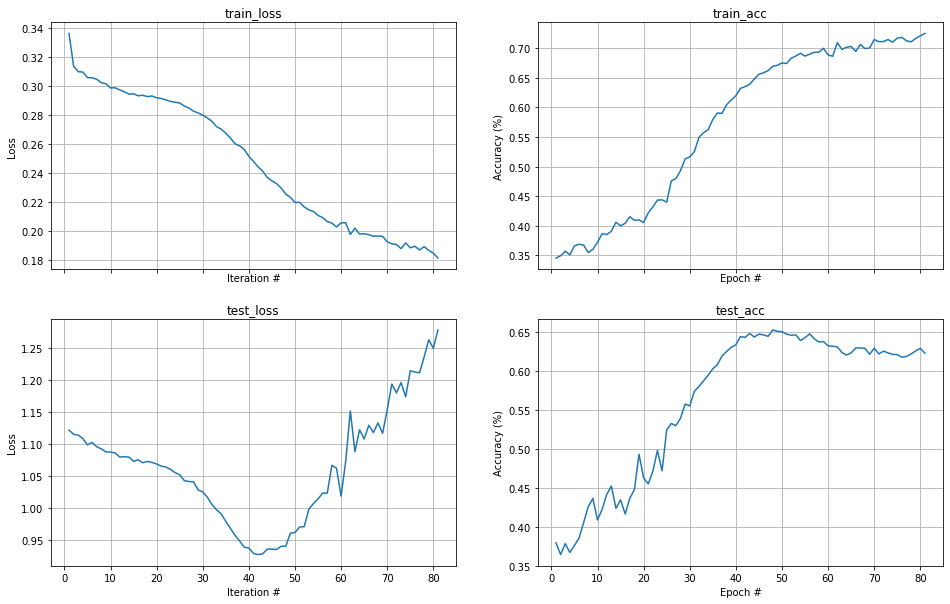

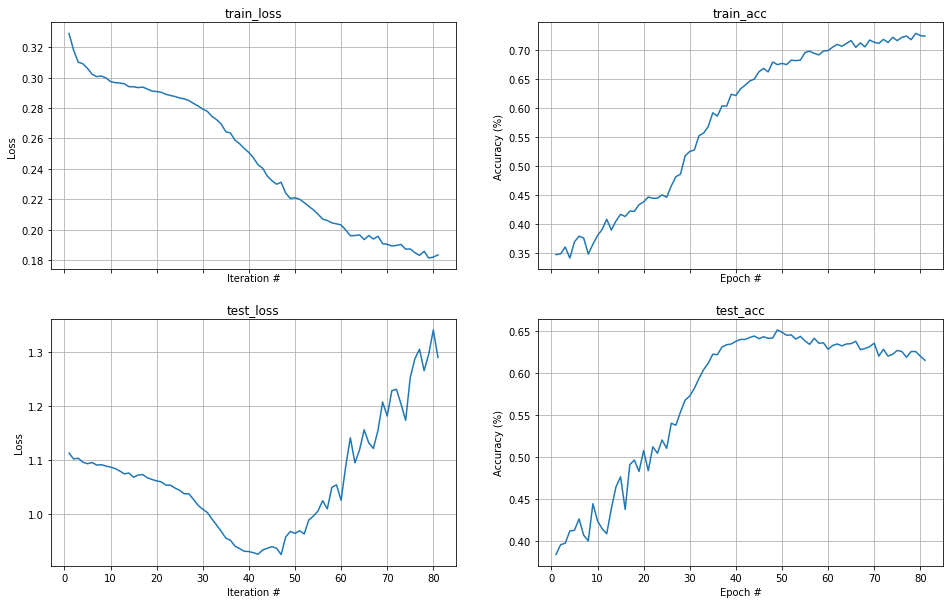

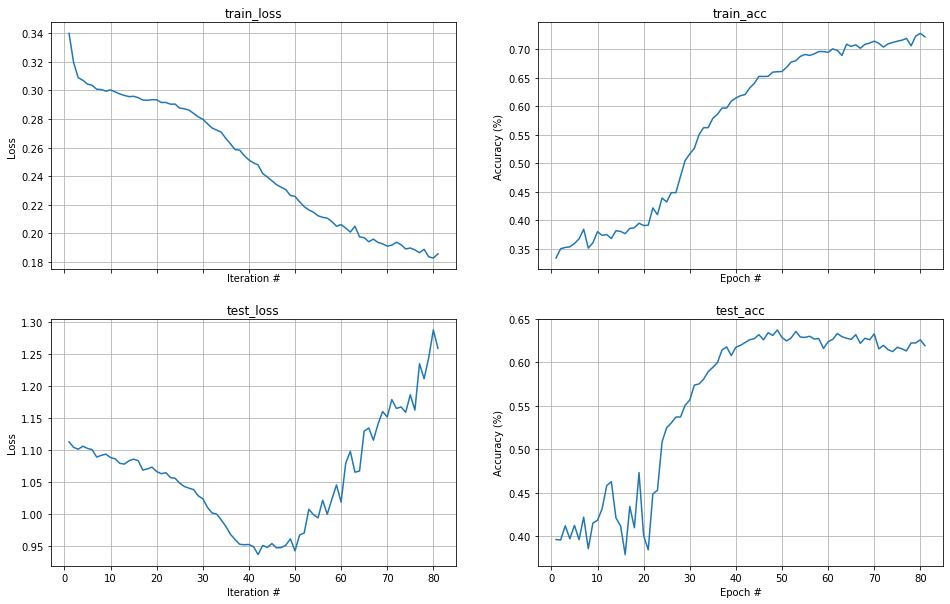

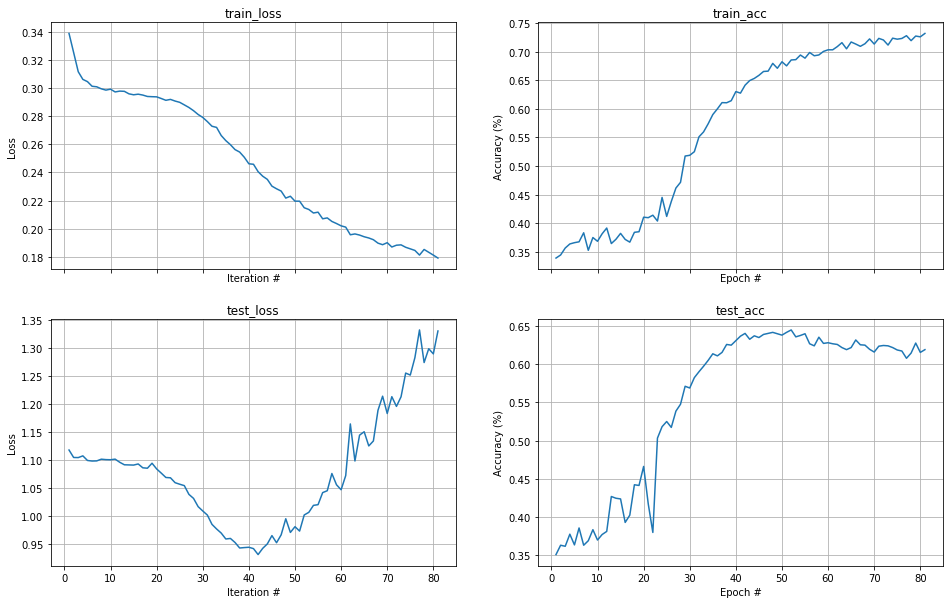

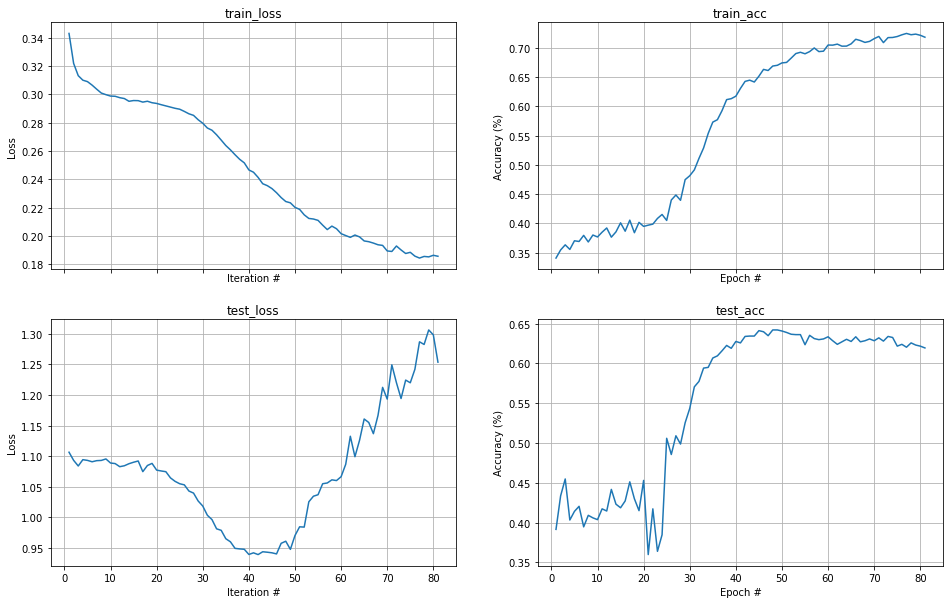

In [16]:
for h in [1, 2, 4, 10, 20]:
    dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
        (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
        shuffle=True, device=device)
    review_parser.build_vocab(ds_train)
    label_parser.build_vocab(ds_train)

    model_attention = SentimentSelfAttention(embeddings,
                                             d_model=D_MODEL,
                                             num_heads=NUM_HEADS,
                                             dropout=DROPOUT,
                                             kqv_dropout=KQV_DROPOUT,
                                             two_layers=TWO_LAYERS,
                                             freeze_embedding=FREEZE_EMB).to(device)

    att_optimizer = torch.optim.Adam(model_attention.parameters(), lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY, betas=BETAS)

    loss_fn = torch.nn.NLLLoss(weight=torch.tensor([1., 1., 1.]).to(device))
    
    plot.plot_fit(train(model_attention, att_optimizer, loss_fn, dl_train, dl_test, max_epochs=81,
          num_batches=500, print_every=10))

## Utils

In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(p.name, p.grad)

In [ ]:
print(model_attention)
print(loss_fn.weight)

In [20]:
import gc
del model_attention
#del model
gc.collect()

1990